## Totale 4/06/2019
### Esercizio 2
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
class args:
    filename = "atsp04062019R1.gml"
    scale = 40
    figsize = 5,5

In [8]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [12]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()
    
    
def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()

In [14]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 870 edges


In [17]:
G.edges(data=True)

OutEdgeDataView([(1, 2, {'dist': 2327}), (1, 3, {'dist': 2925}), (1, 4, {'dist': 4182}), (1, 5, {'dist': 1935}), (1, 6, {'dist': 3126}), (1, 7, {'dist': 1238}), (1, 8, {'dist': 3900}), (1, 9, {'dist': 912}), (1, 10, {'dist': 2238}), (1, 11, {'dist': 442}), (1, 12, {'dist': 4268}), (1, 13, {'dist': 3025}), (1, 14, {'dist': 1839}), (1, 15, {'dist': 1209}), (1, 16, {'dist': 3017}), (1, 17, {'dist': 1179}), (1, 18, {'dist': 3894}), (1, 19, {'dist': 3536}), (1, 20, {'dist': 2587}), (1, 21, {'dist': 1765}), (1, 22, {'dist': 1491}), (1, 23, {'dist': 3748}), (1, 24, {'dist': 2807}), (1, 25, {'dist': 886}), (1, 26, {'dist': 2316}), (1, 27, {'dist': 1363}), (1, 28, {'dist': 1870}), (1, 29, {'dist': 3086}), (1, 30, {'dist': 2407}), (2, 1, {'dist': 2191}), (2, 3, {'dist': 4257}), (2, 4, {'dist': 2707}), (2, 5, {'dist': 2827}), (2, 6, {'dist': 1343}), (2, 7, {'dist': 2283}), (2, 8, {'dist': 2344}), (2, 9, {'dist': 1568}), (2, 10, {'dist': 167}), (2, 11, {'dist': 2528}), (2, 12, {'dist': 3041}), (2,

## ATSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost (length, distance) $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> The tour (a directed cycle that touch exactly once all $n$ nodes) of minimum cost (length, distance)  


### Miller-Tucker-Zemlin lifted formulation (Desrochers-Laporte)
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} &\le n-2 \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, i \not = \{1\}
\end{alignat}
$$
#### SEC with |S|=2

$$ x_{ij} + x_{ji} \le 1 \;\; \forall (i,j) \in A, i <j $$

## Mixed Formulation

In [19]:
root=1

atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),
                     obj=[G[i][j]['dist'] for i,j in G.edges()],
                     vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS, name='u')

atsp_mtz.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')
atsp_mtz.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')
atsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 for i,j in G.edges() if j > i), name='SEC2')

u[root].lb = 1.0
u[root].ub = 1.0

atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)
                   for i in G.nodes() for j in G.nodes()
                   if (i != j) and (i != 1) and (j !=1 ) and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')
atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

atsp_mtz._vars = x
atsp_mtz._graph = G

The lazy cut callback will be transformed into a cut callback

In [20]:
def SEC_cut_callback (model, where):
    if where == gb.GRB.Callback.MIPNODE:
        
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        count = model.cbGet(gb.GRB.Callback.MIPNODE_NODCNT)
        
        if status == gb.GRB.OPTIMAL and count < 10:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph

            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:
                    if len(cut[0]) < len(cut[1]):
                        subtour = (list(cut[0]))
                    else:
                        subtour = (list(cut[1]))

                    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1)

                    break

In [22]:
atsp_mtz.reset()
atsp_mtz.Params.PreCrush = 1
atsp_mtz.Params.lazyConstraints = 0
atsp_mtz.optimize(SEC_cut_callback)

Discarded solution information
Parameter PreCrush unchanged
   Value: 1  Min: 0  Max: 1  Default: 0
Parameter lazyConstraints unchanged
   Value: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1307 rows, 900 columns and 5858 nonzeros
Model fingerprint: 0xac14950e
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.02s
Presolved: 1307 rows, 899 columns, 5858 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)
Found heuristic solution: objective 80645.000000

Root relaxation: objective 2.692205e+04, 139 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

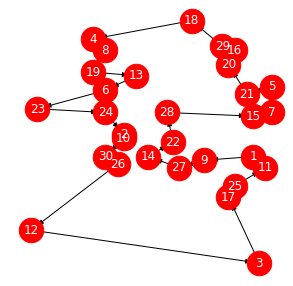

In [23]:
DrawSol(G,x)